## Final Project Submission

Please fill out:
* Student name: Mohammed Siddiqui
* Student pace: full time
* Scheduled project review date/time: 4/23/2021 11am CST
* Instructor name: Claude Fried
* Blog post URL:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.impute import KNNImputer
import xgboost



In [2]:
df =pd.read_csv("./data/train_values.csv")
tr_labels = pd.read_csv("./data/train_labels.csv")


Business Problem:
 * WaterAid has hired us to analyze some waterpoint mapping data they have collected.
 * They would like us to make a model to predict whether a waterpoint is in need of repair.
 * From that model, they would like to know which factures most affect failure rates.
 * Of particular interest is to find out which Local Government Authorities are struggling the most.

# 1. Data Overview

We will be using the Tanzania Waterpoint Mapping data released in 2012.  Dataset is from an active competition on datadriven.org.

Feature descriptions:

* amount_tsh - Total static head (amount water available to waterpoint)
* date_recorded - The date the row was entered
* funder - Who funded the well
* gps_height - Altitude of the well
* installer - Organization that installed the well
* longitude - GPS coordinate
* latitude - GPS coordinate
* wpt_name - Name of the waterpoint if there is one
* num_private -
* basin - Geographic water basin
* subvillage - Geographic location
* region - Geographic location
* region_code - Geographic location (coded)
* district_code - Geographic location (coded)
* lga - Geographic location
* ward - Geographic location
* population - Population around the well
* public_meeting - True/False
* recorded_by - Group entering this row of data
* scheme_management - Who operates the waterpoint
* scheme_name - Who operates the waterpoint
* permit - If the waterpoint is permitted
* construction_year - Year the waterpoint was constructed
* extraction_type - The kind of extraction the waterpoint uses
* extraction_type_group - The kind of extraction the waterpoint uses
* extraction_type_class - The kind of extraction the waterpoint uses
* management - How the waterpoint is managed
* management_group - How the waterpoint is managed
* payment - What the water costs
* payment_type - What the water costs
* water_quality - The quality of the water
* quality_group - The quality of the water
* quantity - The quantity of water
* quantity_group - The quantity of water
* source - The source of the water
* source_type - The source of the water
* source_class - The source of the water
* waterpoint_type - The kind of waterpoint
* waterpoint_type_group - The kind of waterpoint

## 1.1 Cursory Look

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

* There are 40 columns here, and many appear to be duplicates

In [4]:
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


* We can see that a lot of our data appears to be categorical.  Let's see how many columns could be continuous.

In [5]:
df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


*  We have 10 columns that appear to be continuous right now, but that is deceiving.
    * region_code and district_code have numbers, but they are categorical.
    * id and num_private seem to be for internal record keeping.
    * amount_tsh, gps_height, population and construction_year have at least 25% values of 0 which are null
    * I suspect there are zero numbers in latitude and longitude as well

## 1.2 Dealing with the Target Variable

In [6]:
tr_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


In [7]:
tr_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [8]:
tr_labels.status_group.value_counts(normalize=True)


functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

* The majority of the waterpoints are functional, but we need to combine the non functional and functional needs repair

In [9]:
tr_labels['status_group'] = tr_labels['status_group'].map(lambda x: 'needs repair' if x != 'functional' else 'no repair')
df = df.merge(tr_labels, how='left', on='id')
tr_labels.status_group.value_counts(normalize=True)

no repair       0.543081
needs repair    0.456919
Name: status_group, dtype: float64

* This works better and we see that the counts are more even.  We have a binary classification now.

## 1.3 Dropping Excess Columns

In [10]:
df =df.drop([ 'funder', 'gps_height', 'installer', 'wpt_name'
            , 'num_private', 'population', 'public_meeting', 'recorded_by', 'permit',
            'scheme_management', 'scheme_name', 'quantity_group', 'extraction_type',
            'extraction_type_group', 'source', 'payment', 'waterpoint_type' ], axis=1)

* Here, we're dropping some duplicate and problematic columns.
* We can get them back, if necessary.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   longitude              59400 non-null  float64
 4   latitude               59400 non-null  float64
 5   basin                  59400 non-null  object 
 6   subvillage             59029 non-null  object 
 7   region                 59400 non-null  object 
 8   region_code            59400 non-null  int64  
 9   district_code          59400 non-null  int64  
 10  lga                    59400 non-null  object 
 11  ward                   59400 non-null  object 
 12  construction_year      59400 non-null  int64  
 13  extraction_type_class  59400 non-null  object 
 14  management             59400 non-null  object 
 15  ma

* Down to 22 categories.  We will eventually have to cut more.

# 2. Data Analysis and Feature Engineering

## 2.1 Taking care of some oddities

In [12]:
df['date_recorded'] = pd.to_datetime(df['date_recorded'])
df['year_recorded'] = df['date_recorded'].apply(lambda x: x.strftime('%Y')).astype(int)
df['date_recorded'] = df['date_recorded'].apply(lambda x: x.strftime('%Y-%m'))


* Didn't end up using this, but it could be useful if more complete construction_year data comes in.

In [13]:
df.amount_tsh.value_counts(normalize=True)

0.0         0.700993
500.0       0.052222
50.0        0.041616
1000.0      0.025051
20.0        0.024630
              ...   
8500.0      0.000017
6300.0      0.000017
220.0       0.000017
138000.0    0.000017
12.0        0.000017
Name: amount_tsh, Length: 98, dtype: float64

* I suspect(confidently) that 0s have been placed in place of the null values
* Simple logic: If you have 64% of the sources functional, you can't have 70% with 0 tsh.
* Ignore category
* Similar issues with the population and construction year.

In [14]:
df.describe()

,id,amount_tsh,longitude,latitude,region_code,district_code,construction_year,year_recorded
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,34.077427,-5.706033e+00,15.297003,5.629747,1300.652475,2011.921667
std,21453.128371,2997.574558,6.567432,2.946019e+00,17.587406,9.633649,951.620547,0.958758
min,0.000000,0.000000,0.000000,-1.164944e+01,1.000000,0.000000,0.000000,2002.000000
25%,18519.750000,0.000000,33.090347,-8.540621e+00,5.000000,2.000000,0.000000,2011.000000
50%,37061.500000,0.000000,34.908743,-5.021597e+00,12.000000,3.000000,1986.000000,2012.000000
75%,55656.500000,20.000000,37.178387,-3.326156e+00,17.000000,5.000000,2004.000000,2013.000000
max,74247.000000,350000.000000,40.345193,-2.000000e-08,99.000000,80.000000,2013.000000,2013.000000


<AxesSubplot:xlabel='construction_year', ylabel='Count'>

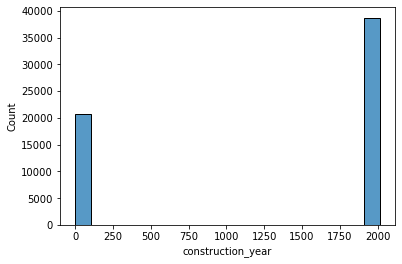

In [15]:
sns.histplot(df.construction_year, bins=20)

* We can't drop 20% of our data and it's not possible to umpute those values in a way that would be helpful.
* Column has to go

In [16]:
'''def cat_comb(df, category, threshold=5):
    series = pd.value_counts(df[category])
    mask = (series / series.sum() * 100).lt(threshold)
    df[category] = np.where(df[category].isin(series[mask].index),'other', df[category])
    return df[category]
'''

"def cat_comb(df, category, threshold=5):\n    series = pd.value_counts(df[category])\n    mask = (series / series.sum() * 100).lt(threshold)\n    df[category] = np.where(df[category].isin(series[mask].index),'other', df[category])\n    return df[category]\n"

In [17]:
df.basin.value_counts(normalize=True)

Lake Victoria              0.172525
Pangani                    0.150505
Rufiji                     0.134276
Internal                   0.131061
Lake Tanganyika            0.108283
Wami / Ruvu                0.100791
Lake Nyasa                 0.085606
Ruvuma / Southern Coast    0.075640
Lake Rukwa                 0.041313
Name: basin, dtype: float64

* There seem to be some basins combined.  

def hashit(df, column):
    return df[column].apply(lambda x: mmh3.hash(x, seed=42, signed=True)&100)

In [18]:
#df['region'] = hashit(df, 'region')
df.lga.value_counts(normalize=True)

Njombe          0.042138
Arusha Rural    0.021077
Moshi Rural     0.021061
Bariadi         0.019815
Rungwe          0.018620
                  ...   
Moshi Urban     0.001330
Kigoma Urban    0.001195
Arusha Urban    0.001061
Lindi Urban     0.000354
Nyamagana       0.000017
Name: lga, Length: 125, dtype: float64

In [19]:
df['lga'] = df['lga'].apply(lambda x: x.split(" ")[0])
df.lga.value_counts()

Njombe       2503
Moshi        1330
Arusha       1315
Bariadi      1177
Singida      1172
             ... 
Ilemela       142
Mafia         132
Tanga          99
Kinondoni      93
Nyamagana       1
Name: lga, Length: 114, dtype: int64

Single value for Nyamangana is peculiar.  Let's look at it.

In [20]:
df[df['lga'] == 'Nyamagana']

,id,amount_tsh,date_recorded,longitude,latitude,basin,subvillage,region,region_code,district_code,...,management_group,payment_type,water_quality,quality_group,quantity,source_type,source_class,waterpoint_type_group,status_group,year_recorded
3676,16551,0.0,2011-07,32.863271,-2.623808,Lake Victoria,Luchelele Ziwani,Mwanza,19,3,...,user-group,never pay,soft,good,enough,shallow well,groundwater,hand pump,needs repair,2011


* Appears to be in a water rich area where such waterpoints aren't necessary.

sns.histplot(df.status_group)



fig = plt.figure(figsize=(20,15))
ax = sns.scatterplot(data=working[working['construction_year'] != 0], x='longitude', y='latitude', alpha=0.2, hue='construction_year', marker='.')
'''
ax.set(  xlabel='Budget($100 Million)',
         ylabel='Return on Investment(%)', 
         title='Returns by Budget',
         xticks=np.arange(0, 340000000, 50000000), 
         yticks=np.arange(0, 51, 10),  )
'''

plt.xlim([29,41])
plt.ylim([-12,0])
plt.show()

In [21]:
df = df.drop(['id', 'amount_tsh', 'date_recorded', 'year_recorded', 'construction_year', 'management'], axis=1)

* These features don't have much use to us at this point.

## 2.2 Categoricals and Continuous Variables

### 2.2.1 Split

In [22]:
df_cont = df[['latitude', 'longitude']]
df_cat = df.drop(['latitude', 'longitude'], axis=1)

### 2.2.2 Continuous Variables

In [23]:
df_cont = pd.DataFrame(df_cont)

<AxesSubplot:xlabel='latitude', ylabel='Count'>

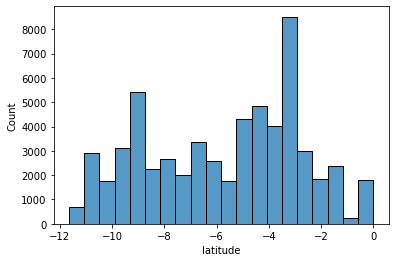

In [24]:
sns.histplot(df_cont.latitude, bins=20)

<AxesSubplot:xlabel='longitude', ylabel='Count'>

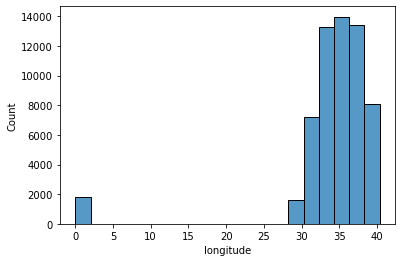

In [25]:
sns.histplot(df_cont.longitude, bins=20)

*  Alright, we got some problematic 0 values which are a placeholder for null
*  Using SimpleImputer with mean or mode would be more problematic.
*  For now, we'll stick with the strategy='ignore' which leaves 0s.

In [26]:
scaler = StandardScaler()

df_cont = scaler.fit_transform(df_cont)
df_cont = pd.DataFrame(df_cont)

### 2.2.3 Categorical Variables

In [27]:
for column in df_cat:
    print(column)
    print (len(df_cat[column].value_counts()))

basin
9
subvillage
19287
region
21
region_code
27
district_code
20
lga
114
ward
2092
extraction_type_class
7
management_group
5
payment_type
7
water_quality
8
quality_group
6
quantity
5
source_type
7
source_class
3
waterpoint_type_group
6
status_group
2


In [28]:
df_cat = df_cat.drop(['subvillage', 'ward', 'source_class', 'water_quality', 'region_code', 'district_code'], axis=1)

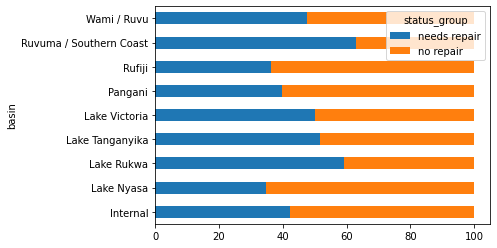

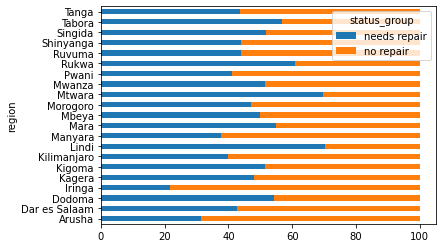

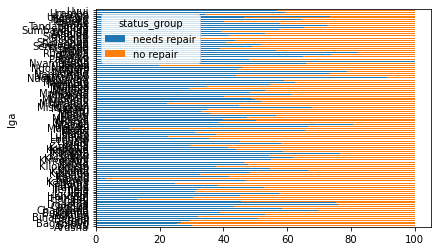

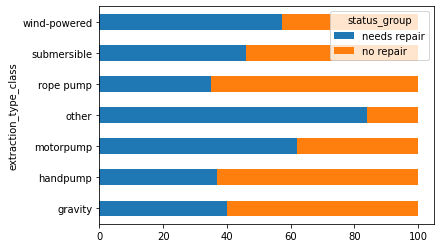

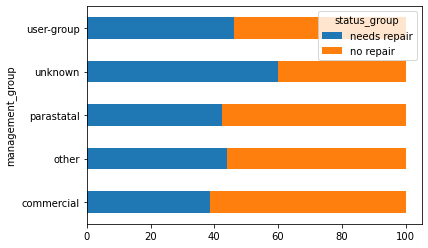

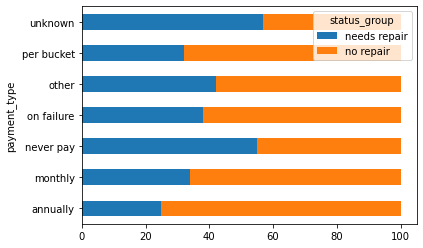

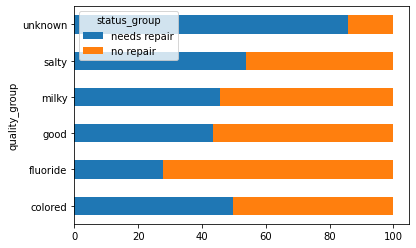

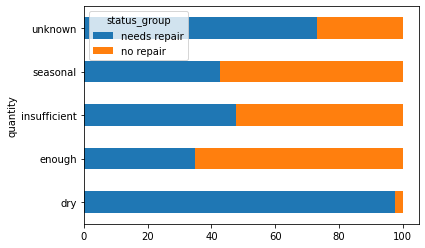

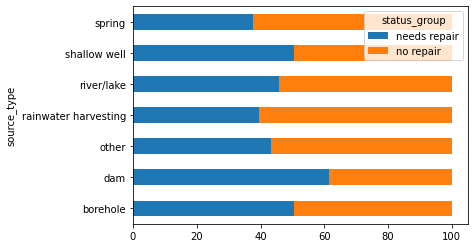

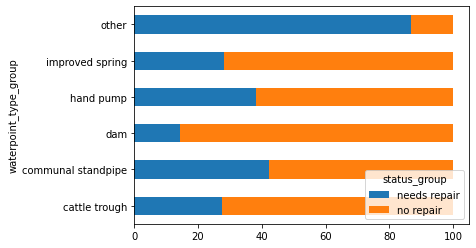

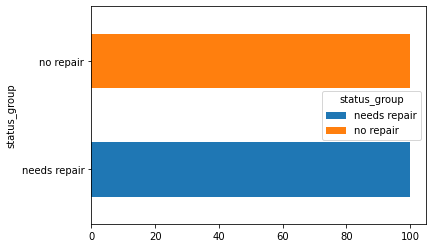

In [29]:
for column in df_cat:
    pd.crosstab(df_cat[column], tr_labels['status_group']
                            ).apply(lambda x: x/x.sum()*100, axis=1
                            ).plot(kind="barh",stacked=True)

In [30]:
for column in df_cat:
    print(df_cat[column].value_counts(normalize=True))

Lake Victoria              0.172525
Pangani                    0.150505
Rufiji                     0.134276
Internal                   0.131061
Lake Tanganyika            0.108283
Wami / Ruvu                0.100791
Lake Nyasa                 0.085606
Ruvuma / Southern Coast    0.075640
Lake Rukwa                 0.041313
Name: basin, dtype: float64
Iringa           0.089125
Shinyanga        0.083872
Mbeya            0.078098
Kilimanjaro      0.073721
Morogoro         0.067441
Arusha           0.056397
Kagera           0.055825
Mwanza           0.052222
Kigoma           0.047407
Ruvuma           0.044444
Pwani            0.044360
Tanga            0.042879
Dodoma           0.037054
Singida          0.035236
Mara             0.033148
Tabora           0.032980
Rukwa            0.030438
Mtwara           0.029125
Manyara          0.026650
Lindi            0.026027
Dar es Salaam    0.013552
Name: region, dtype: float64
Njombe       0.042138
Moshi        0.022391
Arusha       0.022138
Bariadi

* Thints that stand out:
    * Quantity of dry has a huge effect and that's about 10% of wells
    * Payment type of never_pay and unknown have higer repair needs.
        * That's 43% and 14% of all waterpoints
    * LGA has a high amount of variability, so it is very important.

<AxesSubplot:xlabel='lga'>

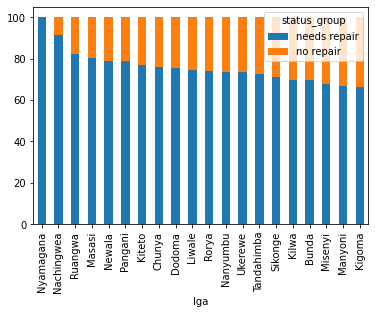

In [31]:
repairc =pd.crosstab(df_cat['lga'], tr_labels['status_group']).apply(lambda x: x/x.sum()*100, axis=1)
repairc =repairc.sort_values(by='needs repair', ascending=False).head(20)
repairc.plot(kind='bar', stacked=True)

*  These are the 20 LGAs that have the highest repair needs by %
*  We notice Nyamagana here.
*  Let's do this for waterpoints where the quantity of water isn't enough.

In [32]:
df_ne = df_cat[df_cat['quantity'] != 'enough']
df_ne.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26214 entries, 1 to 59398
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   basin                  26214 non-null  object
 1   region                 26214 non-null  object
 2   lga                    26214 non-null  object
 3   extraction_type_class  26214 non-null  object
 4   management_group       26214 non-null  object
 5   payment_type           26214 non-null  object
 6   quality_group          26214 non-null  object
 7   quantity               26214 non-null  object
 8   source_type            26214 non-null  object
 9   waterpoint_type_group  26214 non-null  object
 10  status_group           26214 non-null  object
dtypes: object(11)
memory usage: 2.4+ MB


<AxesSubplot:xlabel='lga'>

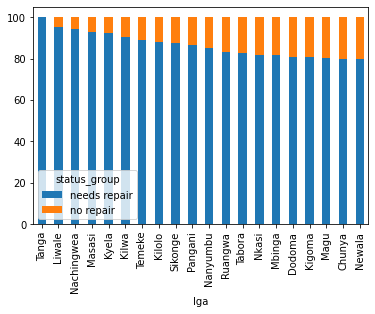

In [33]:
repairc =pd.crosstab(df_ne['lga'], df_ne['status_group']).apply(lambda x: x/x.sum()*100, axis=1)
repairc =repairc.sort_values(by='needs repair', ascending=False).head(20)
repairc.plot(kind='bar', stacked=True)

*  Wow. The LGAs with the highest repair needs are all above 80%

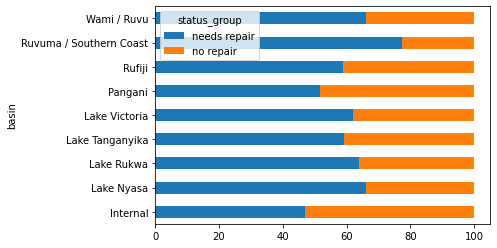

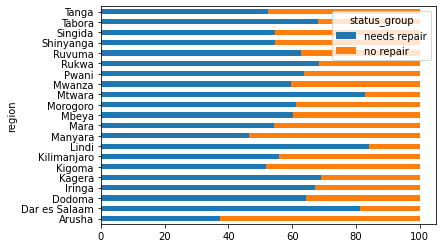

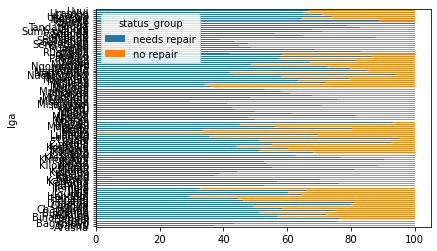

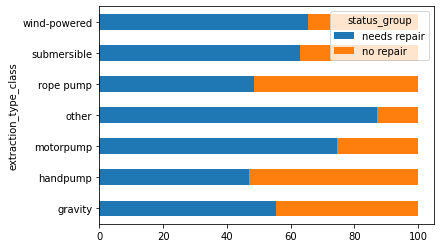

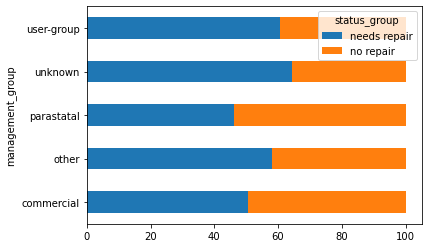

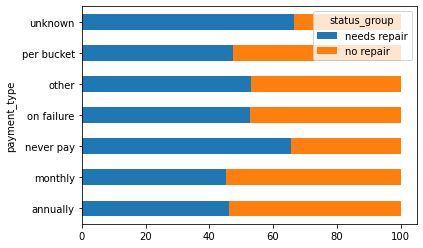

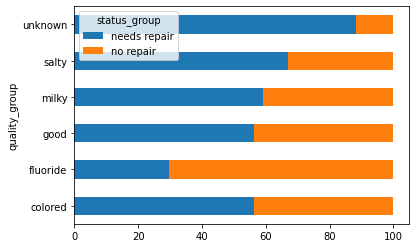

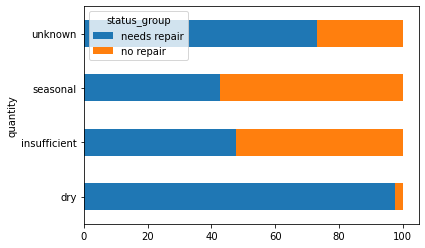

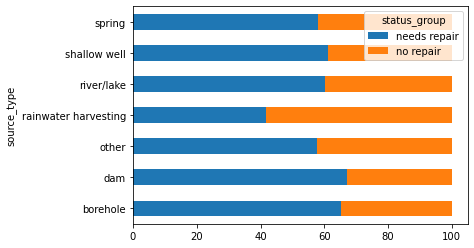

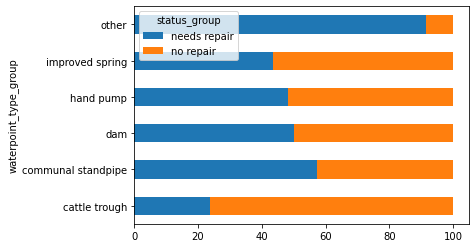

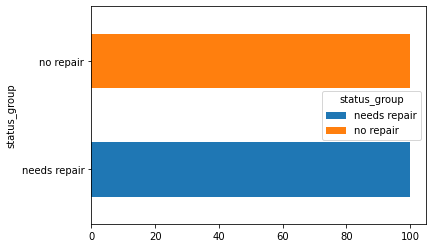

In [34]:
for column in df_ne:
    pd.crosstab(df_ne[column], df_ne['status_group']
                            ).apply(lambda x: x/x.sum()*100, axis=1
                            ).plot(kind="barh",stacked=True)

In [35]:
df.groupby('quantity')['status_group'].value_counts(normalize=True).unstack()

status_group,needs repair,no repair
quantity,,
dry,0.974864,0.025136
enough,0.347677,0.652323
insufficient,0.476766,0.523234
seasonal,0.425926,0.574074
unknown,0.730038,0.269962


([<matplotlib.axis.XTick at 0x1a2ddaf1730>,
 [Text(0, 0, 'dry'),
  Text(1, 0, 'unknown'),
  Text(2, 0, 'insufficient'),
  Text(3, 0, 'seasonal'),
  Text(4, 0, 'enough')])

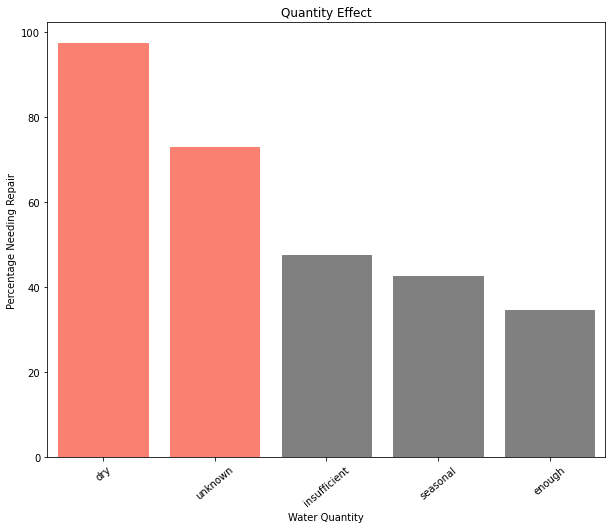

In [36]:
# Quantity chart

rep_q = df.groupby('quantity')['status_group'].value_counts(normalize=True).unstack().reset_index()
rep_q = rep_q.sort_values(['needs repair'], ascending=False).reset_index()
rep_q['needs repair'] = rep_q['needs repair']*100

plt.figure(figsize=(10,8))
ax = sns.barplot(data=rep_q, x='quantity', y='needs repair', ci=False)

for bar in ax.patches:
    if bar.get_height() > 60:
        bar.set_color('salmon')    
    else:
        bar.set_color('grey')

plt.xlabel('Water Quantity')
plt.ylabel('Percentage Needing Repair')
plt.title('Quantity Effect')
plt.xticks(np.arange(5), rotation=40)

([<matplotlib.axis.XTick at 0x1a2dd9e2640>,
 [Text(0, 0, 'unknown'),
  Text(1, 0, 'never pay'),
  Text(2, 0, 'other'),
  Text(3, 0, 'on failure'),
  Text(4, 0, 'monthly'),
  Text(5, 0, 'per bucket'),
  Text(6, 0, 'annually')])

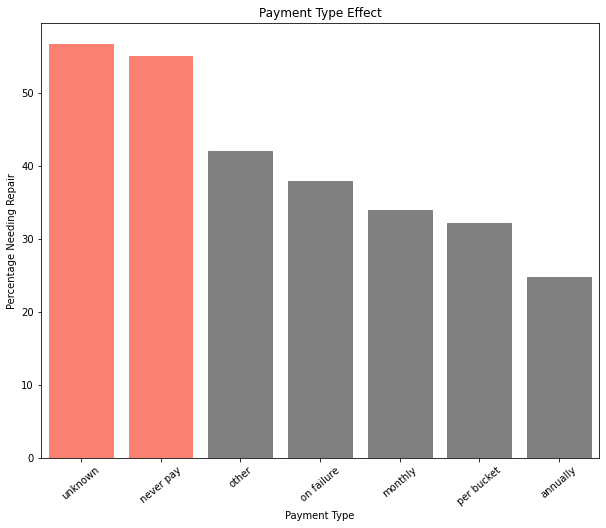

In [37]:
# Payment chart

rep_p = df.groupby('payment_type')['status_group'].value_counts(normalize=True).unstack().reset_index()
rep_p = rep_p.sort_values(['needs repair'], ascending=False).reset_index()
rep_p['needs repair'] = rep_p['needs repair']*100

plt.figure(figsize=(10,8))
ax = sns.barplot(data=rep_p, x='payment_type', y='needs repair', ci=False)

for bar in ax.patches:
    if bar.get_height() > 50:
        bar.set_color('salmon')    
    else:
        bar.set_color('grey')

plt.xlabel('Payment Type')
plt.ylabel('Percentage Needing Repair')
plt.title('Payment Type Effect')
plt.xticks(np.arange(7), rotation=40)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 [Text(0, 0, 'Lindi'),
  Text(1, 0, 'Mtwara'),
  Text(2, 0, 'Rukwa'),
  Text(3, 0, 'Tabora'),
  Text(4, 0, 'Mara'),
  Text(5, 0, 'Dodoma'),
  Text(6, 0, 'Singida'),
  Text(7, 0, 'Kigoma'),
  Text(8, 0, 'Mwanza'),
  Text(9, 0, 'Mbeya'),
  Text(10, 0, 'Kagera'),
  Text(11, 0, 'Morogoro'),
  Text(12, 0, 'Shinyanga'),
  Text(13, 0, 'Ruvuma'),
  Text(14, 0, 'Tanga'),
  Text(15, 0, 'Dar es Salaam'),
  Text(16, 0, 'Pwani'),
  Text(17, 0, 'Kilimanjaro'),
  Text(18, 0, 'Manyara'),
  Text(19, 0, 'Arusha'),
  Text(20, 0, 'Iringa')])

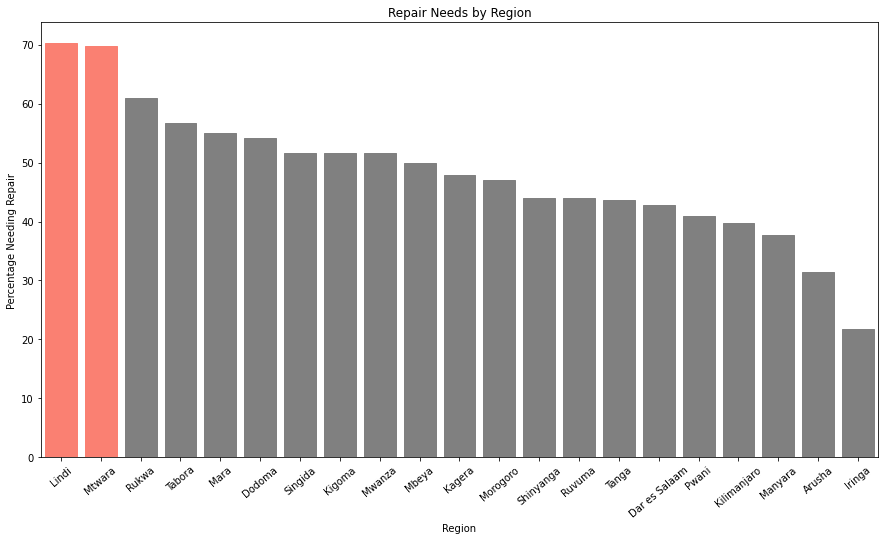

In [38]:
rep_r = df.groupby('region')['status_group'].value_counts(normalize=True).unstack().reset_index()
rep_r = rep_r.sort_values(['needs repair'], ascending=False).reset_index()
rep_r['needs repair'] = rep_r['needs repair']*100

plt.figure(figsize=(15,8))
ax = sns.barplot(data=rep_r, x='region', y='needs repair', ci=False)

for bar in ax.patches:
    if bar.get_height() > 65:
        bar.set_color('salmon')    
    else:
        bar.set_color('grey')

plt.xlabel('Region')
plt.ylabel('Percentage Needing Repair')
plt.title('Repair Needs by Region')
plt.xticks(rotation=40)

# 3. Prep for Modeling

In [39]:
df_cat = df_cat.drop('status_group', axis=1)
df_cat = pd.get_dummies(df_cat)


* We've got to one-hot encode the categoricals in order to do our models.
* Assigning numerical values to the categories would introduce bias

In [40]:
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Columns: 187 entries, basin_Internal to waterpoint_type_group_other
dtypes: uint8(187)
memory usage: 11.0 MB


Number of ohe categores jumped to 187, but we have a lot of data points, so it should be fine

In [41]:
df = pd.concat([df_cont, df_cat], axis=1)

In [42]:
le = LabelEncoder()

tr_labels = le.fit_transform(tr_labels.status_group)


In [43]:
X = df
y = tr_labels

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11)

In [45]:
X_test.shape

(14850, 189)

# 4. Models

## 4.1 Model 1

Decision Tree Classifier

TRAIN
              precision    recall  f1-score   support

Needs Repair       0.99      1.00      0.99     20346
   No Repair       1.00      0.99      0.99     24204

    accuracy                           0.99     44550
   macro avg       0.99      0.99      0.99     44550
weighted avg       0.99      0.99      0.99     44550

TEST
              precision    recall  f1-score   support

Needs Repair       0.75      0.76      0.76      6795
   No Repair       0.80      0.79      0.79      8055

    accuracy                           0.78     14850
   macro avg       0.77      0.77      0.77     14850
weighted avg       0.78      0.78      0.78     14850



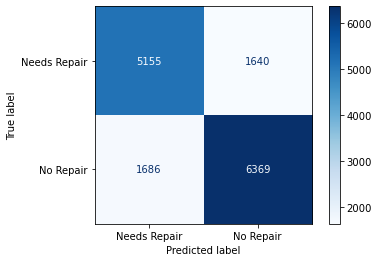

In [46]:
tree = DecisionTreeClassifier(criterion='gini', 
#                            max_features='log2',
#                            min_samples_leaf=2, 
#                            max_depth=20, 
                            class_weight='balanced')
clf_dt = tree.fit(X_train, y_train)

# Test set predictions
pred = tree.predict(X_test)
# Confusion matrix and classification report

pred_tr = tree.predict(X_train)

plot_confusion_matrix(tree, X_test, y_test,
                                 display_labels=['Needs Repair', 'No Repair'],
                                 cmap=plt.cm.Blues)
print('TRAIN')
print(classification_report(y_train, pred_tr, target_names=['Needs Repair', 'No Repair']))

print('TEST')
print(classification_report(y_test, pred, target_names=['Needs Repair', 'No Repair']))


* Recall of 0.76 for Needs Repair isn't bad, but we are definitely overfit.

In [47]:
tree.feature_importances_
df.columns
feature_imp = pd.DataFrame({'feature': df.columns, 'importance': tree.feature_importances_*100})
feature_imp.sort_values(by=['importance'], ascending=False).head(20)

,feature,importance
0,0,25.856608
1,1,25.825097
171,quantity_dry,12.059091
188,waterpoint_type_group_other,6.908221
14,region_Iringa,1.908849
160,payment_type_never pay,1.299850
172,quantity_enough,0.875141
151,extraction_type_class_submersible,0.863653
180,source_type_river/lake,0.757961
173,quantity_insufficient,0.690609


* Latitude and Longitude are being overrepresented here because they are continuous
* Dry quantity and never pay show up as issues.

,feature,importance
3,lga,12.163934
10,source_type,11.366511
6,payment_type,10.771261
2,district_code,10.177237
4,extraction_type_class,10.063785
9,quantity,9.341607
1,region_code,9.285020
0,region,8.750916
5,management_group,4.486133
12,waterpoint_type_group,3.955747


* The above is for the hash trick being kept for reference

## 4.2 Model 2

Random Forest Classifier

### 4.2.1 No changes to hyperparameters

TRAIN
              precision    recall  f1-score   support

Needs Repair       1.00      0.99      0.99     20346
   No Repair       0.99      1.00      0.99     24204

    accuracy                           0.99     44550
   macro avg       0.99      0.99      0.99     44550
weighted avg       0.99      0.99      0.99     44550

TEST
              precision    recall  f1-score   support

Needs Repair       0.80      0.76      0.78      6795
   No Repair       0.81      0.84      0.82      8055

    accuracy                           0.80     14850
   macro avg       0.80      0.80      0.80     14850
weighted avg       0.80      0.80      0.80     14850



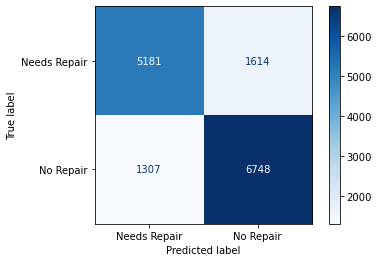

In [48]:
clf = RandomForestClassifier().fit(X_train, y_train)

pred = clf.predict(X_test)

# Test set predictions
pred_tr = clf.predict(X_train)
# Confusion matrix and classification report


plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=['Needs Repair', 'No Repair'],
                                 cmap=plt.cm.Blues)

print('TRAIN')
print(classification_report(y_train, pred_tr, target_names=['Needs Repair', 'No Repair']))

print('TEST')
print(classification_report(y_test, pred, target_names=['Needs Repair', 'No Repair']))

*  Same recall, but we are still overfit.

### 4.2.2. Manual tweaks to hyperparameters

TRAIN
              precision    recall  f1-score   support

Needs Repair       0.89      0.77      0.83     20346
   No Repair       0.83      0.92      0.87     24204

    accuracy                           0.85     44550
   macro avg       0.86      0.85      0.85     44550
weighted avg       0.86      0.85      0.85     44550

TEST
              precision    recall  f1-score   support

Needs Repair       0.84      0.71      0.77      6795
   No Repair       0.78      0.89      0.83      8055

    accuracy                           0.81     14850
   macro avg       0.81      0.80      0.80     14850
weighted avg       0.81      0.81      0.80     14850



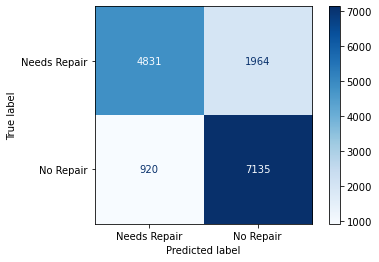

In [49]:
clf = RandomForestClassifier( n_estimators=200, 
                            max_samples=0.3,
                            max_depth=20,  
                            class_weight='balanced'
                            ).fit(X_train, y_train)

pred = clf.predict(X_test)

# Test set predictions
pred_tr = clf.predict(X_train)
# Confusion matrix and classification report


plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=['Needs Repair', 'No Repair'],
                                 cmap=plt.cm.Blues)

print('TRAIN')
print(classification_report(y_train, pred_tr, target_names=['Needs Repair', 'No Repair']))

print('TEST')
print(classification_report(y_test, pred, target_names=['Needs Repair', 'No Repair']))

*  Overfitting improved.  Recall went down to 0.71.

In [50]:
feature_imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_*100})
feature_imp.sort_values(by=['importance'], ascending=False).head(20)

,feature,importance
1,1,14.391109
0,0,14.110561
171,quantity_dry,10.664175
188,waterpoint_type_group_other,4.731956
172,quantity_enough,4.700465
149,extraction_type_class_other,3.948417
160,payment_type_never pay,2.723362
173,quantity_insufficient,1.832634
147,extraction_type_class_handpump,1.373928
163,payment_type_per bucket,1.361375


Based on these, let's try to see what's important.
* Quantity is very important, especially dry and enough.
* Only use 1 geographic column. Region, especially Kigoma and Iringa shows up here.
    * I still like lga more just because of the discrepancies seen in the graph.
    * This also fits our business problem most.
* Extraction Type: Other and Gravity
* Waterpoint Type: Other and communal standpipe
* Payment Type: Never pay, per bucket, monthly, unknown
* Source Type: Borehole, shallow well

### 4.2.3 RFC with Grid Search

In [51]:


rfg = RandomForestClassifier()

param_grid ={'bootstrap': [True],
    'max_depth': [20, 30, 40],
    'min_samples_leaf': [2, 4],
    'min_samples_split': [2, 5],
    'n_estimators': [200, 400],
    'class_weight': ['balanced']
    }

rf_grid = GridSearchCV(estimator = rfg, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring = 'recall')

In [52]:
rf_grid.fit(X_train, y_train)

params_rf = rf_grid.best_params_
params_rf

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  5.8min finished


{'bootstrap': True,
 'class_weight': 'balanced',
 'max_depth': 20,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 200}

* The parameters below were given by the grid search.
* I've commented out the fit just because it takes 15 minutes each time.

TRAIN
              precision    recall  f1-score   support

Needs Repair       0.84      0.73      0.78     20346
   No Repair       0.80      0.88      0.84     24204

    accuracy                           0.81     44550
   macro avg       0.82      0.81      0.81     44550
weighted avg       0.81      0.81      0.81     44550

TEST
              precision    recall  f1-score   support

Needs Repair       0.82      0.71      0.76      6795
   No Repair       0.78      0.87      0.82      8055

    accuracy                           0.80     14850
   macro avg       0.80      0.79      0.79     14850
weighted avg       0.80      0.80      0.79     14850



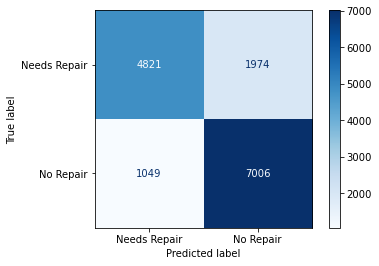

In [53]:
rfg = RandomForestClassifier( n_estimators=400, 
                            max_samples=0.25,
                            min_samples_leaf= 2,
                            min_samples_split=5,
                            max_depth=20,  
                            class_weight='balanced'
                            ).fit(X_train, y_train)

pred = rfg.predict(X_test)

# Test set predictions
pred_tr = rfg.predict(X_train)
# Confusion matrix and classification report


plot_confusion_matrix(rfg, X_test, y_test,
                                 display_labels=['Needs Repair', 'No Repair'],
                                 cmap=plt.cm.Blues)

print('TRAIN')
print(classification_report(y_train, pred_tr, target_names=['Needs Repair', 'No Repair']))

print('TEST')
print(classification_report(y_test, pred, target_names=['Needs Repair', 'No Repair']))

* Overfitting issue is minimal, but the recall score remains at 0.71 for Needs Repair.

## 4.3 Gradient Boosting

TRAIN
              precision    recall  f1-score   support

Needs Repair       0.86      0.73      0.79     20346
   No Repair       0.80      0.90      0.85     24204

    accuracy                           0.82     44550
   macro avg       0.83      0.82      0.82     44550
weighted avg       0.83      0.82      0.82     44550

TEST
              precision    recall  f1-score   support

Needs Repair       0.83      0.70      0.76      6795
   No Repair       0.78      0.88      0.82      8055

    accuracy                           0.80     14850
   macro avg       0.80      0.79      0.79     14850
weighted avg       0.80      0.80      0.79     14850



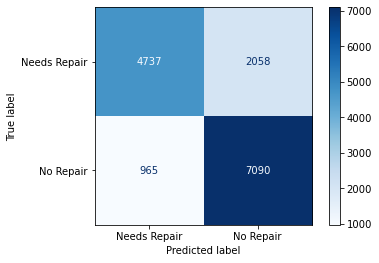

In [54]:
xgb_clf = xgboost.XGBClassifier()
xgb_clf.fit(X_train, y_train)
pred = xgb_clf.predict(X_test)
pred_tr = xgb_clf.predict(X_train)



plot_confusion_matrix(xgb_clf, X_test, y_test,
                                 display_labels=['Needs Repair', 'No Repair'],
                                 cmap=plt.cm.Blues)

print('TRAIN')
print(classification_report(y_train, pred_tr, target_names=['Needs Repair', 'No Repair']))

print('TEST')
print(classification_report(y_test, pred, target_names=['Needs Repair', 'No Repair']))

* I had high hopes for this, but recall is down to 0.70.

## 4.4 Balanced Random Forest Classifier

* Even the slight class imbalance is giving priority to the recall score for "No Repair" rather than "Needs Repair"
* Hopefully this version of the RFC helps

In [55]:
from imblearn.ensemble import BalancedRandomForestClassifier

blclf =BalancedRandomForestClassifier(n_estimators=400, 
                            max_samples=0.3,
                            min_samples_leaf= 2,
                            min_samples_split=5,
                            max_depth=20,
                            class_weight= 'balanced')

blclf.fit(X_train, y_train)
pred = blclf.predict(X_test)
pred_tr = blclf.predict(X_train)

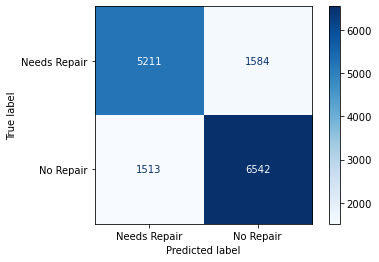

In [56]:
plot_confusion_matrix(blclf, X_test, y_test,
                                 display_labels=['Needs Repair', 'No Repair'],
                                 cmap=plt.cm.Blues)

In [57]:


print('TRAIN')
print(classification_report(y_train, pred_tr, target_names=['Needs Repair', 'No Repair']))

print('TEST')
print(classification_report(y_test, pred, target_names=['Needs Repair', 'No Repair']))

TRAIN
              precision    recall  f1-score   support

Needs Repair       0.80      0.80      0.80     20346
   No Repair       0.83      0.83      0.83     24204

    accuracy                           0.82     44550
   macro avg       0.81      0.81      0.81     44550
weighted avg       0.82      0.82      0.82     44550

TEST
              precision    recall  f1-score   support

Needs Repair       0.77      0.77      0.77      6795
   No Repair       0.81      0.81      0.81      8055

    accuracy                           0.79     14850
   macro avg       0.79      0.79      0.79     14850
weighted avg       0.79      0.79      0.79     14850



In [58]:
feature_imp = pd.DataFrame({'feature': df.columns, 'importance': blclf.feature_importances_*100})
feature_imp.sort_values(by=['importance'], ascending=False).head(20)

,feature,importance
171,quantity_dry,12.419196
1,1,9.688905
0,0,9.133746
172,quantity_enough,5.916922
188,waterpoint_type_group_other,5.729064
149,extraction_type_class_other,4.964774
160,payment_type_never pay,2.916578
173,quantity_insufficient,1.901231
147,extraction_type_class_handpump,1.810086
14,region_Iringa,1.745545


* These are pretty much the same as what we got with the RFC

## 4.4.1 Balanced RFC Grid Search

In [59]:
param_grid ={'bootstrap': [True],
    'max_depth': [20, 40],
    'min_samples_split': [2, 5],
    'n_estimators': [200, 400],
    'class_weight': ['balanced']
    }

bal_grid = GridSearchCV(estimator = blclf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring = 'recall')

In [60]:
bal_grid.fit(X_train, y_train)

params_bl = bal_grid.best_params_
params_bl

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  2.8min finished


{'bootstrap': True,
 'class_weight': 'balanced',
 'max_depth': 20,
 'min_samples_split': 2,
 'n_estimators': 400}

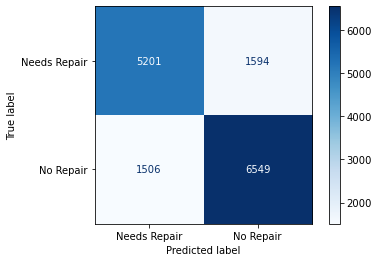

In [61]:
blclf =BalancedRandomForestClassifier(n_estimators=400, 
                            max_samples=0.3,
                            min_samples_leaf= 2,
                            min_samples_split=2,
                            max_depth=20,
                            class_weight= 'balanced')

blclf.fit(X_train, y_train)
pred = blclf.predict(X_test)
pred_tr = blclf.predict(X_train)

plot_confusion_matrix(blclf, X_test, y_test,
                                 display_labels=['Needs Repair', 'No Repair'],
                                 cmap=plt.cm.Blues)

In [62]:
print('TRAIN')
print(classification_report(y_train, pred_tr, target_names=['Needs Repair', 'No Repair']))

print('TEST')
print(classification_report(y_test, pred, target_names=['Needs Repair', 'No Repair']))

TRAIN
              precision    recall  f1-score   support

Needs Repair       0.80      0.80      0.80     20346
   No Repair       0.83      0.83      0.83     24204

    accuracy                           0.82     44550
   macro avg       0.82      0.82      0.82     44550
weighted avg       0.82      0.82      0.82     44550

TEST
              precision    recall  f1-score   support

Needs Repair       0.78      0.77      0.77      6795
   No Repair       0.80      0.81      0.81      8055

    accuracy                           0.79     14850
   macro avg       0.79      0.79      0.79     14850
weighted avg       0.79      0.79      0.79     14850



* The Needs Repair recall is up to 0.77 which is quite an improvement.  We'll end up going with this.

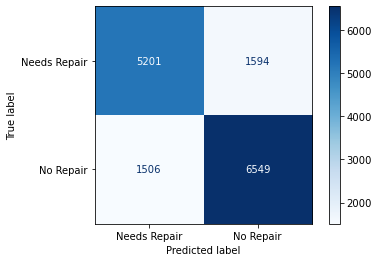

In [63]:
plot_confusion_matrix(blclf, X_test, y_test,
                                 display_labels=['Needs Repair', 'No Repair'],
                                 cmap=plt.cm.Blues)

# 5. Model Selection

The main metric we're going for her is the recall score for the "Need Repair" class.

Here, I'm only including models that weren't overfit:

* Regular Random Forest(with and without GridSearch) and Xgboost gave us a recall of 0.71 for Needs Repair.
* Both Balanced Random Forest Classifier models gave us a recall of 0.77 and they have the same parameters.
* We'll choose Model 4


# 6. Conclusion

## 6.1 Results

* The recall of our model in finding waterpoints in need of repair was 0.77.  This means that our model correctly labeled 77% of the waterpoints in need of repair.

* The precision of our model was 0.78 which is quite close to our recall score.  In layman's terms, if we sent someone to a location where this model indicated a need for repair, the waterpoint would be in need of repair 78% of the time.

* There is a delicate balance between precision and recall where increasing one decreases the other.  In this case, where lack of water can mean the difference between life or death, having a higher sensitivity(recall) is of more benefit.  In those 22% of cases where the waterpoint is still funcitoning when someone goes to check on it, it would advisable to run a further inspection to see if the waterpoint will need repair soon.

## 6.2 Next Steps

* Even the small class imbalance is still and issue in terms of finding the best recall score as the GridSearch looks for the highest recall score which often tries to maximize the overall recall score, rather than the one for the specific class that we need.

* I would like to do something about the 0 values for latitude and longitude.  Taking the mean lat/long for that particular LGA or Ward and assigining it to the 0 value makes most sense to me.

* Figure out how to separate the urban areas from the rural areas.

* The construction dates would be useful if we had the values for all waterpoints in order to calculate age, which is obviously a very important factor.  Another feature that would be of great value would be records about maintainance/repairs.

For reference: The report observed that LGAs allocated nearly all their financial and
human resources for the construction of new water points, disregarding the essential tasks of
maintenance, building capacity, monitoring, and providing technical backstopping to sustain
functionality. MoW officials interviewed during the assessment attributed the high failure rate to a
lack of sufficient capacity of local institutions within the DCs and skewed incentives for spending
on new infrastructure. -US Aid https://pdf.usaid.gov/pdf_docs/PA00WH9Z.pdf


 In the Hai District in the Kilimanjaro Region 200,000 people in 55 villages are served by gravity systems from sources in the rainforest on the slopes of Mount Kilimandjaro. Until the early 1990s the water systems were in bad shape: Local communities did not maintain the infrastructure, water quality was poor and some systems even failed to provide any water. The national water policies of 1991 and 2002, which emphasized local participation and ownership as well as payment for water and metering, turned the situation around. http://www.arcworld.org/downloads/Water-and-a-church-in-tanzania.pdf